# Inertial Navigation
## Data Fusion: IMU + GPS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate

In [163]:
# Number of samples
Tend = 10.
N = 100
h = Tend/N

# Create a time vector
time = np.linspace(0, Tend, N+1)

# Displacement
displacement = 100 * np.sin(np.pi/20*time)
velocity = 1/h * np.diff(displacement)
accel = 1/h * np.diff(velocity)
noise_var = 1e-1
noise = np.sqrt(noise_var) * np.random.randn(N-1)
accel_noisy = accel + noise

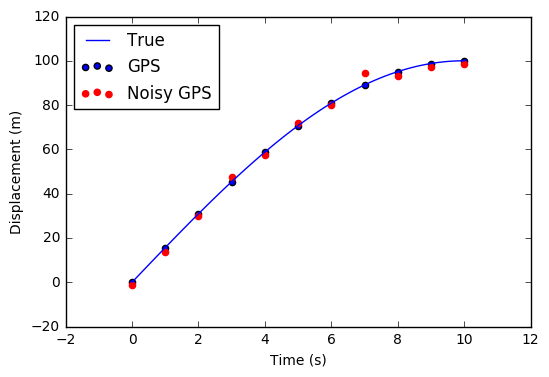

In [182]:
# Create GPS data by subsampling the true displacements and adding Gaussian noise
gps_dec = 10
gps_var = 4  # A standard deviation of around 2m is typical of GPS in good operating conditions
time_gps = time[0::gps_dec]
displacement_gps = displacement[0::gps_dec]
displacement_gps_noisy = displacement_gps + np.sqrt(gps_var) * np.random.randn(11)

# Plot the GPS data
plt.plot(time[0:N+1], displacement)
plt.scatter(time_gps, displacement_gps)
plt.scatter(time_gps, displacement_gps_noisy, color='red')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend(['True', 'GPS', 'Noisy GPS'], loc=2)
plt.show()

We have different measurement matrices $H$ depending on whether, at each time step, we have 1) only accelerometer data or 2) both GPS and accelerometer data.

For the accel only update: $\large H_a = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$

Whilst for the combined: $\large H_s = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}$

The measurement noise for the combined update looks like

$\large R_{combined} = \begin{bmatrix} \sigma_{gps}^2 & 0 \\ 0 & \sigma_{accel}^2 \end{bmatrix}$

In [173]:
# State transition matrix
F = np.array([[1, h, (h**2)/2], [0, 1, h], [0, 0, 1]])
# Measurements
Ha = np.array([0, 0, 1])
Hs = np.array([[1, 0, 0], [0, 0, 1]])

# Process noise
Q = np.diag([0, 0, 10])

# Measurement noise
Ra = .1
Rs = np.array([[gps_var, 0], [0, .1]])

In [174]:
Nstep = len(time)-2

# Initial state
x = np.array([displacement[0], velocity[0], accel[0]]).T
#x = np.zeros([3]) # Uncomment to try the filter with zero-initial-knowledge

# Initial covariance
P = np.diag([1, 1, 1])

# Run through time
xstore = np.zeros([3, Nstep])
for i in range(Nstep):
    # Predict
    x = F.dot(x)
    P = F.dot(P).dot(F.T) + Q
    # Do GPS if there is a reading available
    if time[i] in time_gps:
        y = np.array([displacement_gps_noisy[i/gps_dec], accel[i]]) - Hs.dot(x)
        S = Hs.dot(P).dot(Hs.T) + Rs
        K = P.dot(Hs.T).dot(np.linalg.matrix_power(S, -1))
        x = x + K.dot(y)
        P = (np.eye(3) - K.dot(Hs)).dot(P)
    else:
        y = accel[i] - Ha.dot(x)
        S = Ha.dot(P).dot(Ha.T) + Ra
        K = P.dot(Ha.T).dot(1/S)
        x = x + K.dot(y)
        P = (np.eye(3) - K.dot(Ha)).dot(P)
    # Store
    xstore[:,i] = x

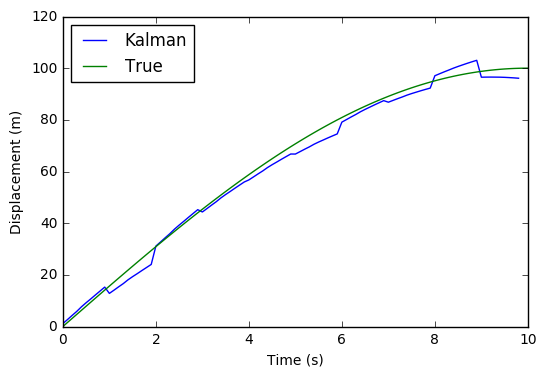

Final error 3m (3%)


In [178]:
plt.plot(time[0:N-1], xstore[0,:])
plt.plot(time[0:N+1], displacement)
#plt.plot(time_gps, displacement_gps)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend(['Kalman', 'True'], loc=2)
plt.show()
print("Final error %dm (%d%%)" % (abs(xstore[0,-1] - displacement[-1]), \
                                  100*abs(xstore[0,-1]-displacement[-1])/displacement[-1]))

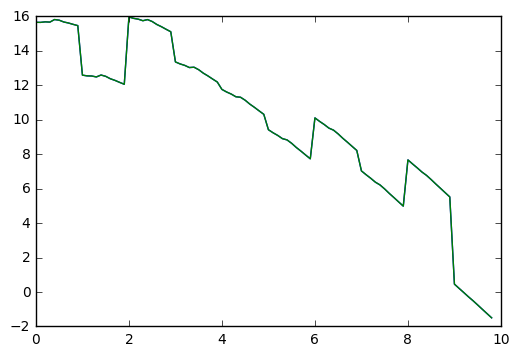

In [185]:
plt.plot(time[0:N-1], xstore[1,:])
plt.show()